# Influence of region, skill and patch on predictability in League of Legends

Last month, I used [random forests to predict the winner of League of Legends games](http://www.trailofpapers.net/2015/10/playing-in-random-forests-in-league-of.html). Since then I have downloaded more datasets from different regions, different ELOs, and on different patches. In this notebook, I will show that Korean games are easier to predict due to "open mids," high skill games are faster and easier to predict than low-skill games, and show how the Preseason 2016 patch influenced the game.

Code used in this notebook can be found at https://github.com/map222/lolML.

### Table of contents
[Region differences](#regions)

[Skill differences](#skill)

[Team ranked vs solo queue](#team)

[Preseason 2016](#2016)

### Load libraries, API key, and datasets

In [87]:
import requests, json
import numpy as np
from src import API_io
import importlib
import pandas as pd
import pickle
import os
from src import feature_calc
import matplotlib.pyplot as plt
import src.plotting as lol_plt
%matplotlib inline
import pdb
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load sklearn package 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [2]:
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML'
os.chdir(working_dir)
with open(working_dir+ '\\api_key.txt', 'r') as api_file:
    api_key =  api_file.read()

Load the datasets in. These datasets were scraped using the Region Scraper Notebook which identifies good players in the featured games, and takes games from their history.

In [16]:
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML\\notebooks'
os.chdir(working_dir)
with open('EUW combined_df.pickle', 'rb') as pickle_file:
    euw_timelines_df = pickle.load(pickle_file)
with open('KR combined_df.pickle', 'rb') as pickle_file:
    kr_timelines_df = pickle.load(pickle_file)
with open('NA combined_df.pickle', 'rb') as pickle_file:
    na_timelines_df = pickle.load(pickle_file)
with open('Low ELO combined_df.pickle', 'rb') as pickle_file:
    low_timelines_df = pickle.load(pickle_file)
with open('Preseason2016 combined_df.pickle', 'rb') as pickle_file:
    pre2016_timelines_df = pickle.load(pickle_file)
with open('Season 2015 Team ranked combined_df.pickle', 'rb') as pickle_file:
    team_timelines_df = pickle.load(pickle_file)

Create some secondary features.

In [18]:
euw_timelines_df = [feature_calc.calc_secondary_features(x) for x in euw_timelines_df]
na_timelines_df = [feature_calc.calc_secondary_features(x) for x in na_timelines_df]
kr_timelines_df = [feature_calc.calc_secondary_features(x) for x in kr_timelines_df]
low_timelines_df = [feature_calc.calc_secondary_features(x) for x in low_timelines_df]
pre2016_timelines_df = [feature_calc.calc_secondary_features(x) for x in pre2016_timelines_df]
team_timelines_df = [feature_calc.calc_secondary_features(x) for x in team_timelines_df]
euw_timelines_df = feature_calc.calc_second_diff(euw_timelines_df)
na_timelines_df = feature_calc.calc_second_diff(na_timelines_df)
kr_timelines_df = feature_calc.calc_second_diff(kr_timelines_df)
low_timelines_df = feature_calc.calc_second_diff(low_timelines_df)
pre2016_timelines_df = feature_calc.calc_second_diff(pre2016_timelines_df)
team_timelines_df = feature_calc.calc_second_diff(team_timelines_df)

These are the important features, as found in prior investigations.

In [19]:
important_col = ['blue_inhibs', 'blue_barons', 'drag_diff', 'first_baron', 'first_inhib',
                 'gold_diff', 'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
                 'red_inhibs', 'tower_diff']
timeline_end = 55
time_indices = np.arange(5, timeline_end, 5)

Set up matplotlib so graphs are pretty.

In [84]:
import matplotlib as mpl
mpl.rc('font', size=20)
mpl.rc('lines', linewidth=2)
mpl.rc('figure',figsize=[8, 6])

<a id='regions'></a>
## How different is each region?

Korea is famed for its great players, and "open mid" philosophy. Are we able to see those attributes in our model? First, let's plot the distribution of game lengths.

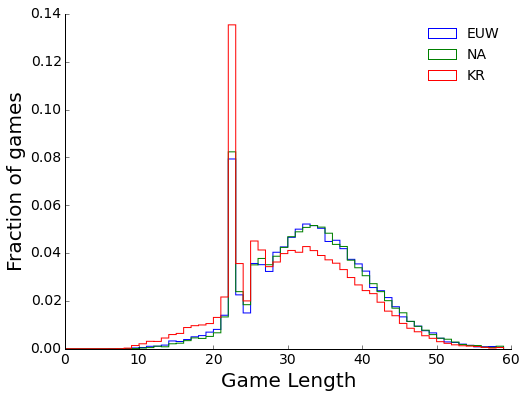

In [29]:
fig, ax = plt.subplots(1, figsize = [8, 6])
euw_lengths =np.array( euw_timelines_df[0]['game_length'])
na_lengths = np.array( na_timelines_df[0]['game_length'])
kr_lengths = np.array( kr_timelines_df[0]['game_length'])
plt.hist(euw_lengths, bins = range(0, 60), histtype='step', normed=True, label = 'EUW')
plt.hist(na_lengths, bins = range(0, 60), histtype='step', normed=True, label = 'NA')
plt.hist(kr_lengths, bins = range(0, 60), histtype='step', normed=True, label = 'KR')
lol_plt.prettify_axes(ax)
plt.xlabel('Game Length')
ax.set_ylabel('Fraction of games')
plt.legend(frameon=False, fontsize = 14);

NA and EUW games are of similar length. Korean games, however, are shorter, with more games ending before 20 minutes, and many more surrenders at twenty. The famed "open mid" attitude is indeed true.
### Are regions similarly predictable?
Given these differences, we can still ask, are the regions similarly predictable? First, I will create a scoring function to apply to each timepoint.

In [92]:
# Since the previous post, I've found that these hyperparameters increase predictability, and reduce run time
rfc = RandomForestClassifier(n_jobs = -1, n_estimators = 25, max_features = 'sqrt',
                             max_depth=1, min_samples_leaf=10, min_samples_split=25)
def cross_validate_df(cur_df, n_samples = 20000):
    sample_df = cur_df.sample(min(cur_df.shape[0], n_samples))
    return cross_validation.cross_val_score(rfc, sample_df[important_col], sample_df['winner'], cv=4, n_jobs = -1)

Now we can apply the scoring function to each region, and plot the results.

In [32]:
kr_scores = list(map(cross_validate_df, kr_timelines_df))
na_scores = list(map(cross_validate_df, na_timelines_df))
euw_scores = list(map(cross_validate_df, euw_timelines_df))

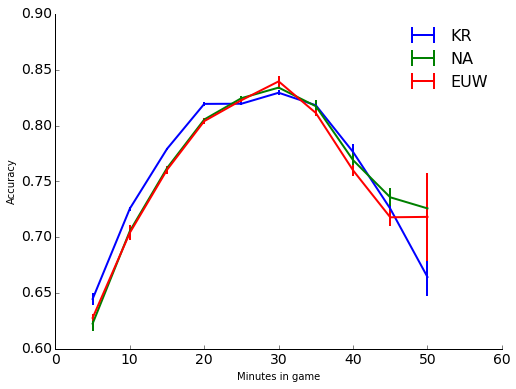

In [88]:
fig, ax = plt.subplots(1, figsize = [8, 6])
cv = np.shape(euw_scores)[1]
plt.errorbar(time_indices, np.mean(kr_scores, 1), np.std(kr_scores, 1) / np.sqrt(cv), label = 'KR', capsize = 0)
plt.errorbar(time_indices, np.mean(na_scores, 1), np.std(na_scores, 1) / np.sqrt(cv), label = 'NA', capsize = 0)
plt.errorbar(time_indices, np.mean(euw_scores, 1), np.std(euw_scores, 1) / np.sqrt(cv), label = 'EUW', capsize = 0)
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy')
plt.xlabel('Minutes in game')
plt.xlim([0, 60])
ax.set_ylim([0.6, 0.9])
plt.legend(frameon=False, fontsize = 16);

Given the frequency of "open mids," Korean games are easier to predict during the first twenty minutes. However, once all of the early surrenders are no longer predicted, each region behaves basically the same. We can try to confirm this by using forests trained on one region to predict the outcomes of a different region.

In [38]:
def score_cross_region(train_df, test_df, n_samples = 20000):
    # train a random forest classifier on training data from one region, then score it on a different region
    train_sample_df = train_df.sample(min(train_df.shape[0], n_samples))
    rfc.fit(train_sample_df[important_col], train_sample_df['winner'])
    return rfc.score(test_df[important_col], test_df['winner'])

In [39]:
na_eu_cross_scores = [score_cross_region(x, y) for x,y in zip(na_timelines_df, euw_timelines_df)]
eu_na_cross_scores = [score_cross_region(x, y) for x,y in zip(euw_timelines_df, na_timelines_df)]
eu_kr_cross_scores = [score_cross_region(x, y) for x,y in zip(euw_timelines_df, kr_timelines_df)]
na_kr_cross_scores = [score_cross_region(x, y) for x,y in zip(na_timelines_df, kr_timelines_df)]

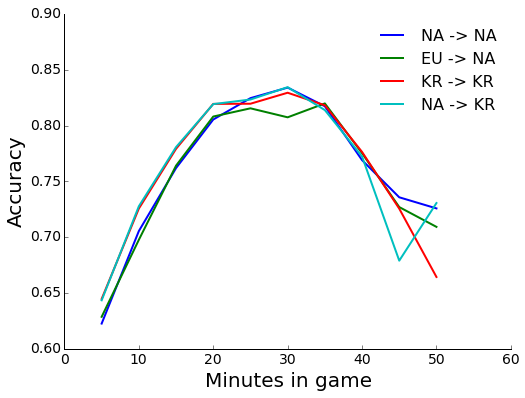

In [77]:
fig, ax = plt.subplots(1, figsize = [8, 6])
plt.plot(time_indices, np.mean(na_scores, 1), label = 'NA -> NA')
plt.plot(time_indices, eu_na_cross_scores, label = 'EU -> NA')
plt.plot(time_indices, np.mean(kr_scores, 1), label = 'KR -> KR')
plt.plot(time_indices, na_kr_cross_scores, label = 'NA -> KR')
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy')
plt.xlabel('Minutes in game')
plt.xlim([0, 60])
ax.set_ylim([0.6, 0.9])
plt.legend(frameon=False, fontsize = 16);

Using EU data to predict NA does well, with a strange dip of 2-3% at 30 minutes. I have no idea what the difference there could be. Using NA to predict KR also does well, showing a higher probability at the pre-20 minute timepoints. This probably reflects that once the losing team goes "open mid," the winning team then gains a large advantage that the model can use.
<a id='skill'></a>
## How does skill level impact predictability?
Next I wanted to see how skill influences the predictability of games. One might assume that better players are able to exploit advantages, and make games more predictable. First, let's look at game lengths for low and high ELO games. I got low ELO games by scraping the games of Kaceytron (probably the funniest streamer out there), and the people she played against. High ELO games come from players in featured games.

Low skill mean length: 37.6115551116, High skill mean length: 32.5614677361


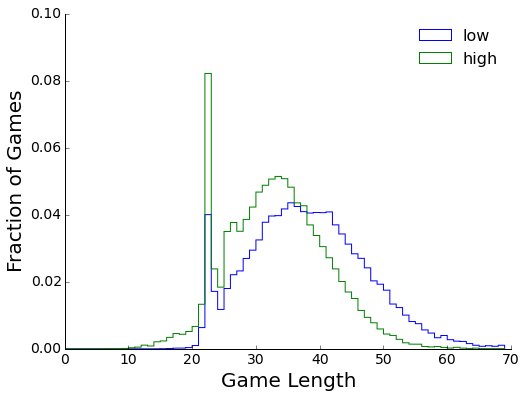

In [73]:
fig, ax = plt.subplots(1, figsize = [8, 6])
low_lengths =np.array( low_timelines_df[0]['game_length'])
high_lengths = np.array( na_timelines_df[0]['game_length'])
plt.hist(low_lengths, bins = range(0, 70), histtype='step', normed=True, label = 'low')
plt.hist(high_lengths, bins = range(0, 70), histtype='step', normed=True,label = 'high')
lol_plt.prettify_axes(plt.gca())
plt.xlabel('Game Length')
plt.ylabel('Fraction of Games')
plt.ylim([0, 0.1])
plt.legend(frameon=False, fontsize = 16);
print('Low skill mean length: ' + str(low_lengths.mean() ) + ', High skill mean length: ' +  str(high_lengths.mean()) )

Low skilled players surrender less, and play longer games (~5 minutes longer). As someone who was played games from Bronze to Gold, this is likely due to less skilled players not knowing to take objectives after team fights, and generally not being able to press advantages.

How does this effect predictability?

In [52]:
low_scores = [cross_validate_df(x) for x in low_timelines_df]
low_high_cross_scores = [score_cross_region(x, y) for x,y in zip(low_timelines_df, na_timelines_df)]

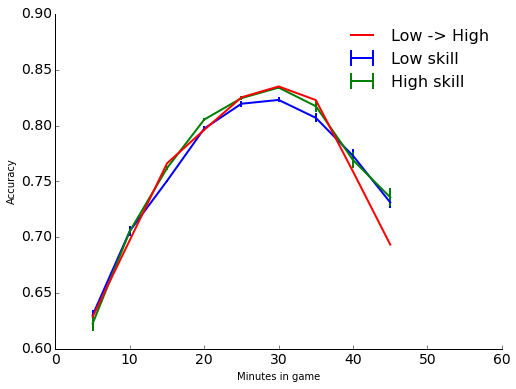

In [94]:
fig, ax = plt.subplots(1, figsize = [8, 6])
plt.errorbar(time_indices[:-1], np.mean(low_scores, 1)[:-1], np.std(low_scores, 1)[:-1] / np.sqrt(cv), label = 'Low skill', capsize = 0)
plt.errorbar(time_indices[:-1], np.mean(na_scores, 1)[:-1], np.std(na_scores, 1)[:-1] / np.sqrt(cv), label = 'High skill', capsize = 0)
plt.plot(time_indices[:-1], low_high_cross_scores[:-1], label = 'Low -> High')
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy')
plt.xlabel('Minutes in game')
plt.xlim([0, 60])
plt.ylim([0.6, 0.9])
plt.legend(frameon=False, fontsize=16);

High skill games are slightly easier to predict than low-skill games, especially at 20-35 minutes. Is this due to better players or different game states? If we use low skill models to predict high skill games, we get a similar accuracy, so it is likely that high skill games simply have larger differences between teams at those timepoints.
<a id='team'></a>
### Team ranked vs Solo queue

Another way we can try to look at this is to plot solo queue games versus team ranked games. Theoretically, the coordination in team ranked games should be higher than Solo Queue games, and make things more predictable. I scraped Team Ranked games using my ELO Scraper notebook, which took games from Challenger Ranked Teams during the 2015 season. There are a lot fewer Team Ranked games, ~1,200 total.

Solo mean length: 32.5614677361, Team mean length: 30.6936


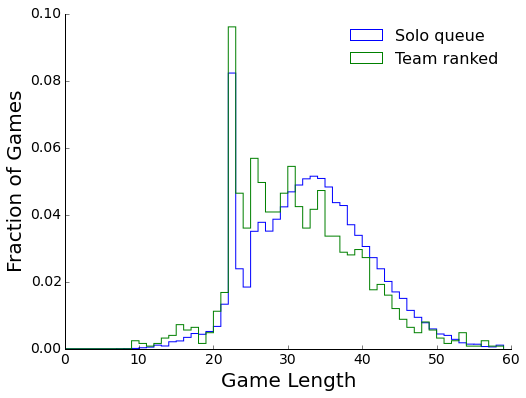

In [72]:
fig, ax = plt.subplots(1, figsize = [8, 6])
solo_lengths = np.array( na_timelines_df[0]['game_length'])
team_lengths =np.array( team_timelines_df[0]['game_length'])
plt.hist(solo_lengths, bins = range(0, 60), histtype='step', normed=True, label = 'Solo queue')
plt.hist(team_lengths, bins = range(0, 60), histtype='step', normed=True,label = 'Team ranked')
lol_plt.prettify_axes(plt.gca())
plt.xlabel('Game Length')
plt.ylabel('Fraction of Games')
plt.ylim([0, 0.1])
plt.legend(frameon=False, fontsize = 16)
print('Solo mean length: ' + str(solo_lengths.mean() ) + ', Team mean length: ' +  str(team_lengths.mean()) )

Team ranked games average two minutes quicker than solo queue games.

How predictable are they?

In [65]:
team_scores = [cross_validate_df(x) for x in team_timelines_df]

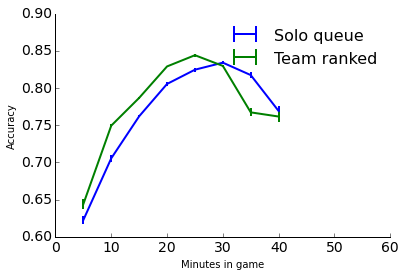

In [90]:
plt.errorbar(time_indices[:-2], np.mean(na_scores[:-2], 1), np.std(low_scores[:-2], 1) / np.sqrt(cv), label = 'Solo queue', capsize = 0)
plt.errorbar(time_indices[:-2], np.mean(team_scores[:-2], 1), np.std(na_scores[:-2], 1) / np.sqrt(cv), label = 'Team ranked', capsize = 0)
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy')
plt.xlabel('Minutes in game')
plt.xlim([0, 60])
plt.ylim([0.6, 0.9])
plt.legend(frameon=False, fontsize=16);

That's the biggest difference yet! And that's with many fewer games to train on. There's a 5% difference in predictability at 10 minutes. It seems that better teams get ahead early, and are better able at pressing that advantage to end the game quickly. It would be interesting to compare these results to professional games, which is something I plan to do. If you were to use these models for betting, you should use team ranked games, rather than solo queue!
<a id='2016'></a>
## Preseason 2016
Finally, with the preseason for 2016 upon us, games appear to be snowballing more, and ending quickly. Is that feeling translated to the model?

2106 mean length: 29.1938018333, 2015 mean length: 32.5614677361


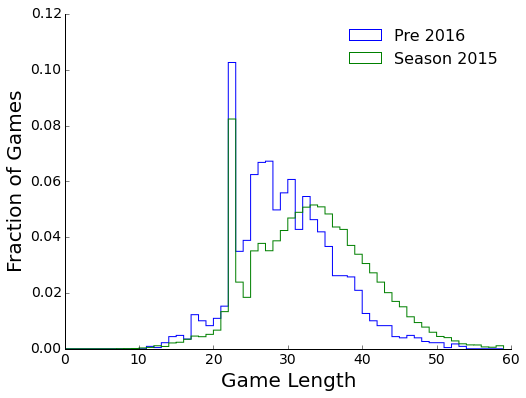

In [75]:
fig, ax = plt.subplots(1, figsize = [8, 6])
pre_2016_lengths =np.array( pre2016_timelines_df[0]['game_length'])
season_2015_lengths = np.array( na_timelines_df[0]['game_length'])
plt.hist(pre_2016_lengths, bins = range(0, 60), histtype='step', normed=True, label = 'Pre 2016')
plt.hist(season_2015_lengths, bins = range(0, 60), histtype='step', normed=True,label = 'Season 2015')
lol_plt.prettify_axes(plt.gca())
plt.xlabel('Game Length')
plt.ylabel('Fraction of Games')
plt.legend(frameon=False, fontsize=16);
print('2106 mean length: ' + str(pre_2016_lengths.mean() ) + ', 2015 mean length: ' +  str(season_2015_lengths.mean()) )

Preseason 2016 games are averaging 3 minutes less than 2015 games. How about predictability?

In [ ]:
pre_2016_scores = [cross_validate_df(x) for x in pre2016_timelines_df]
season_2015_scores = [cross_validate_df(x) for x in na_timelines_df]

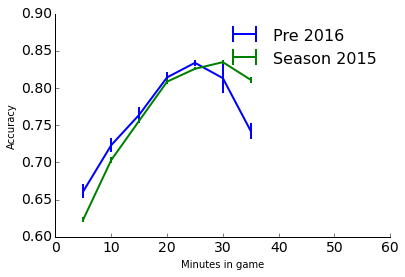

In [91]:
plt.errorbar(time_indices[:-3], np.mean(pre_2016_scores[:-3], 1), np.std(pre_2016_scores[:-3], 1) / np.sqrt(4), label = 'Pre 2016', capsize=0)
plt.errorbar(time_indices[:-3], np.mean(season_2015_scores[:-3], 1), np.std(season_2015_scores[:-3], 1) / np.sqrt(4), label = 'Season 2015', capsize=0)
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy')
plt.xlabel('Minutes in game')
plt.xlim([0, 60])
plt.ylim([0.6, 0.9])
plt.legend(fontsize = 16,frameon=False);

Preseason 2016 is about 5% easier to predict 5-10 minutes into the game, reflecting the increased ability to snowball. Things converge around 20 minutes though, due to surrenders and teams simply losing. I would also not read too much into the 35 minute timepoint, as there are only a limited number of preseason games that the model has to train with.

That's it for this update. In the future, I want to use this model to explore hyperparameters of random forests, and try out some other machine learning algorithms to see which works best.